# ssDNA-Hi-C Analysis Pipeline Tutorial

This notebook demonstrates the **end-to-end processing pipeline** for a single sample using the `sshicstuff` toolkit.
The goal is to transform raw *sparse contact matrices* into biologically interpretable profiles and summary statistics.


In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '4'
os.environ.pop("MPLBACKEND", None)

import sys
import pandas as pd
from sshicstuff import main as _entrypoint

from os.path import join

## 1. Inputs overview

Each run of the pipeline requires the following input files:

Each run of the pipeline requires several input files:

- **`-m / --sparse-matrix`** — Sparse contact matrix produced by *hicstuff* (usually the `graal.tsv` file).  
  Contains pairwise fragment contacts (frag_a, frag_b, contacts).
- **`-c / --oligo-capture`** — CSV/TSV file describing the designed capture oligos (probes).  
  Each probe includes chromosome, start, end, and sequence coordinates. See **design tutorial** to see how to built it. 
- **`-f / --fragments`** — Fragment list generated during genome digestion by *hicstuff*.  
  Provides genomic coordinates of each restriction fragment.
- **`-C / --chr-coord`** — Chromosome coordinate file containing chromosome names, lengths, and centromere/telomere positions.  
  Used for rebinning and aggregation steps.
- **`-a / --additional-groups`** *(optional)* — Probe grouping file allowing the definition of custom probe sets or regions for aggregation.

---

And the following optionnal arguments

- **-b / --binning-sizes** — List of binning sizes for rebinning (e.g. 1000, 10000 bp)
- **-E / --exclude** — Chromosomes to exclude from the analysis
- **-F / --force** — Overwrite existing files
- **-I / --inter** — Keep only inter-chromosomal contacts
- **-n / --flanking-number** — Number of flanking fragments to remove around ssDNA probes (default: 2)
- **-N / --normalize** — Normalize contact frequencies
- **-o / --output** — Output directory
- **-r / --cis-range** — Cis interaction distance in bp (default: 50,000)
- **--binning-aggregate-cen** — Bin size used for centromere aggregation (default: 10 kb)
- **--binning-aggregate-telo** — Bin size used for telomere aggregation (default: 1 kb)
- **--window-size-cen** — Centromere aggregation window (default: 150 kb)
- **--window-size-telo** — Telomere aggregation window (default: 15 kb)
- **--copy-inputs** — Copy all input files to the output directory for reproducibility


In [2]:

INPUTS_DIR = "../test_data/inputs"
OUTPUTS_DIR = "../test_data/outputs"

graal = "Graal_sample_for_pipeline.txt"
capture = "capture_oligo_for_pipeline.csv"
coords = "chr_coordinates_for_pipeline.tsv"
frags = "fragments_list_for_pipeline.txt"
groups = "probe_groups_for_pipeline.tsv"

ARGS = [
    "-m", join(INPUTS_DIR, graal),
    "-c", join(INPUTS_DIR, capture),
    "-C", join(INPUTS_DIR, coords),
    "-f", join(INPUTS_DIR, frags),
    "-a", join(INPUTS_DIR, groups),
    "-n", "2",
    "-I",
    "-N",
    "-o", OUTPUTS_DIR,
    "-b", "1000",
    "-b", "2000",
    "-b", "5000",
    "-b", "10000",
    "-r", "50000",
    "--binning-aggregate-cen", "10000",
    "--binning-aggregate-telo", "1000",
    "--window-size-cen", "150000",
    "--window-size-telo", "15000",
    "--copy-inputs",
    "-F",
]

Running bash command to execute full pipeline

In [13]:
cmd = "sshicstuff pipeline " + " ".join(ARGS)

In [14]:
!{cmd}

INFO :: [START] : 2025-10-27 14:27:38
INFO :: [Pipeline] : Graal_sample_for_pipeline 
INFO :: [Copy] : Graal_sample_for_pipeline.txt copied.
INFO :: [Copy] : capture_oligo_for_pipeline.csv copied.
INFO :: [Copy] : fragments_list_for_pipeline.txt copied.
INFO :: [Copy] : chr_coordinates_for_pipeline.tsv copied.
INFO :: [Copy] : probe_groups_for_pipeline.tsv copied.
INFO :: [Associate] : Associate oligo/probe name to fragment/read ID that contains it.
INFO :: [Associate] : Creating a new oligo_capture table : capture_oligo_for_pipeline_fragments_associated.csv
INFO :: [Associate] : oligos associated to fragments successfully.
INFO :: [Copy] : capture_oligo_for_pipeline_fragments_associated.csv copied.
INFO :: [Sparse Matrix Graal (dsdna)] : creating a new sparse matrix with only dsDNA reads
INFO :: [Sparse Matrix Graal (dsdna)] dsDNA only contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_dsdna_only.txt
INFO :: [Coverage] : Calculate the coverage for dsDNA reads only
INFO :

If we look at every step individually, here is what it does :

In [9]:
## Associate
ARGS = [
    "associate",
    "-o",  join(INPUTS_DIR, capture),
    "-f",  join(INPUTS_DIR, frags),
    "-F",
]
cmd = "sshicstuff " + " ".join(ARGS)

In [10]:
!{cmd}

INFO :: [Associate] : Associate oligo/probe name to fragment/read ID that contains it.
INFO :: [Associate] : Creating a new oligo_capture table : capture_oligo_for_pipeline_fragments_associated.csv
INFO :: [Associate] : oligos associated to fragments successfully.


In [18]:
capture_associated_path = join(OUTPUTS_DIR, "inputs/capture_oligo_for_pipeline_fragments_associated.csv")
df_associated = pd.read_table(capture_associated_path, sep=",")
df_associated.loc[:, ["name", "fragment", "fragment_start", "fragment_end"]].head()


,name,fragment,fragment_start,fragment_end
0,Native_URA-L-17213-MfeI-RC,74823,0,289
1,Native_URA-L-16220-MfeI-RC,74824,289,655
2,Native_URA-L-15683-SspI-RC,74825,655,1021
3,Native_URA-L-9924-MfeI-RC,74826,1021,1387
4,Native_URA-L-6532-MfeI-RC,74827,1387,1727


In [32]:
## dsdnaonly
ARGS = [
    "dsdnaonly",
    "-m", join(INPUTS_DIR, graal),
    "-c", capture_associated_path,
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_dsdna_only.tsv"),
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [33]:
!{cmd}

INFO :: [Sparse Matrix Graal (dsdna)] dsDNA only contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_dsdna_only.tsv


In [38]:
df_dsdnaonly = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_dsdna_only.tsv"), sep="\t")
df_dsdnaonly.head()

,74796,74796.1,9869147
0,0,1,15
1,0,2,2
2,0,3,40
3,0,4,59
4,0,5,7


In [35]:
## ssdna only
ARGS = [
    "ssdnaonly",
    "-m", join(INPUTS_DIR, graal),
    "-c", capture_associated_path,
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_ssdna_only.tsv"),
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [36]:
!{cmd}

INFO :: [Sparse Matrix Graal (ssdna)] ssDNA only contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_ssdna_only.tsv


In [39]:
df_ssdnaonly = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_ssdna_only.tsv"), sep="\t")
df_ssdnaonly.head()

,43,43.1,354
0,8579,74853,1
1,74823,74824,3
2,74823,74825,28
3,74823,74826,2
4,74823,74827,1


In [8]:
## Coverage
ARGS = [
    "coverage",
    "-m", join(INPUTS_DIR, graal),
    "-f", join(INPUTS_DIR, frags),
    "--outdir", OUTPUTS_DIR,
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [9]:
!{cmd}

INFO :: [Coverage] Contacts coverage file saved to ../test_data/outputs/Graal_sample_for_pipeline_contacts_coverage.bedgraph
INFO :: [Coverage] Coverage calculation completed.


In [11]:
df_coverage = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_contacts_coverage.bedgraph"), sep="\t")
df_coverage.head()

,chr1,0,336,1672
0,chr1,336,476,566
1,chr1,476,509,28
2,chr1,509,1149,1415
3,chr1,1149,1410,1418
4,chr1,1410,1492,147


In [14]:
## Coverage with bin sizes
ARGS = [
    "coverage",
    "-m", join(INPUTS_DIR, graal),
    "-f", join(INPUTS_DIR, frags),
    "-c", join(INPUTS_DIR, coords),
    "-b", "5000",
    "--outdir", OUTPUTS_DIR,
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [15]:
!{cmd}

INFO :: [Coverage] Binned contacts coverage file saved to ../test_data/outputs/Graal_sample_for_pipeline_contacts_coverage_5kb.bedgraph
INFO :: [Coverage] Coverage calculation completed.


In [16]:
df_coverage5kb = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_contacts_coverage_5kb.bedgraph"), sep="\t")
df_coverage5kb.head()

,chr1,0,5000,13705.4286
0,chr1,5000,10000,14191.6026
1,chr1,10000,15000,10078.1177
2,chr1,15000,20000,11310.8650
3,chr1,20000,25000,9171.4862
4,chr1,25000,30000,7814.2164


In [19]:
## Filter
ARGS = [
    "filter",
    "-m", join(INPUTS_DIR, graal),
    "-c", capture_associated_path,
    "-f", join(INPUTS_DIR, frags),
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_filtered.tsv"),
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [20]:
!{cmd}

INFO :: [Filter] : Filtered contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_filtered.tsv


In [25]:
filtered_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_filtered.tsv")
df_filtered = pd.read_table(filtered_path, sep="\t")
df_filtered.head()

,frag_a,frag_b,contacts,chr_a,start_a,end_a,size_a,gc_content_a,name_a,type_a,sequence_a,chr_b,start_b,end_b,size_b,gc_content_b,name_b,type_b,sequence_b
0,0,8579,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr4,64397,64699,302,0.337748,chr4-64420-CDC13,ss,CAACTCACTTGTGGATATCTTCAACAATTTAATAGAAATGAATAGA...
1,0,68254,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr15,996325,996743,418,0.397129,chr15-996452-MEK1,ds,ATGAGACCGTTGTATAGCTGCAACCTTGCAACCAAAGATGATATTG...
2,0,74831,2,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr_artificial_dsDNA,2485,2851,366,0.071038,Native_URA-L-3728-SspI-RC,ss,tTCTAATAGTCCTAGGACaCACATGAAGTaCTCATTTGTCAAAtTA...
3,0,74835,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr_artificial_dsDNA,3583,3949,366,0.081967,Native_URA-L-1560-SspI-RC,ss,GCTTAGCGCAGCAGTCAAATAgTGAGTAAATTGGTgCGCAACAATG...
4,0,74851,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr_artificial_ssDNA,1387,1753,366,0.076503,Probe_URA-L-6532-MfeI-RC,ss,TTCTTGACTTgCTTCTTCTTTGGATaCTACATTTGTGCCAtTTGTA...


In [28]:
## Profile probes-only (give a frequency matrix around probes vs probe)
ARGS = [
    "profile",
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-f", filtered_path,
    "-a", join(INPUTS_DIR, groups),
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_0kb_profile_frequencies.tsv"),
    "-N",
    "-F",
    "--probes-only"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [29]:
!{cmd}

In [49]:
## Plot matric of the probes-only generated above
probes_matrix_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_probes_matrix.tsv")
ARGS = [
    "plotmatrix",
    "-m", probes_matrix_path,
    "-o", join(OUTPUTS_DIR, "probes_matrix_plot.png"),
    "-v", "0",
    "-V", "0.01",
]
cmd = "sshicstuff " + " ".join(ARGS)

In [50]:
!{cmd}

Detected locale "C" with character encoding "ANSI_X3.4-1968", which is not UTF-8.
Qt depends on a UTF-8 locale, and has switched to "C.UTF-8" instead.
If this causes problems, reconfigure your locale. See the locale(1) manual
for more information.
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


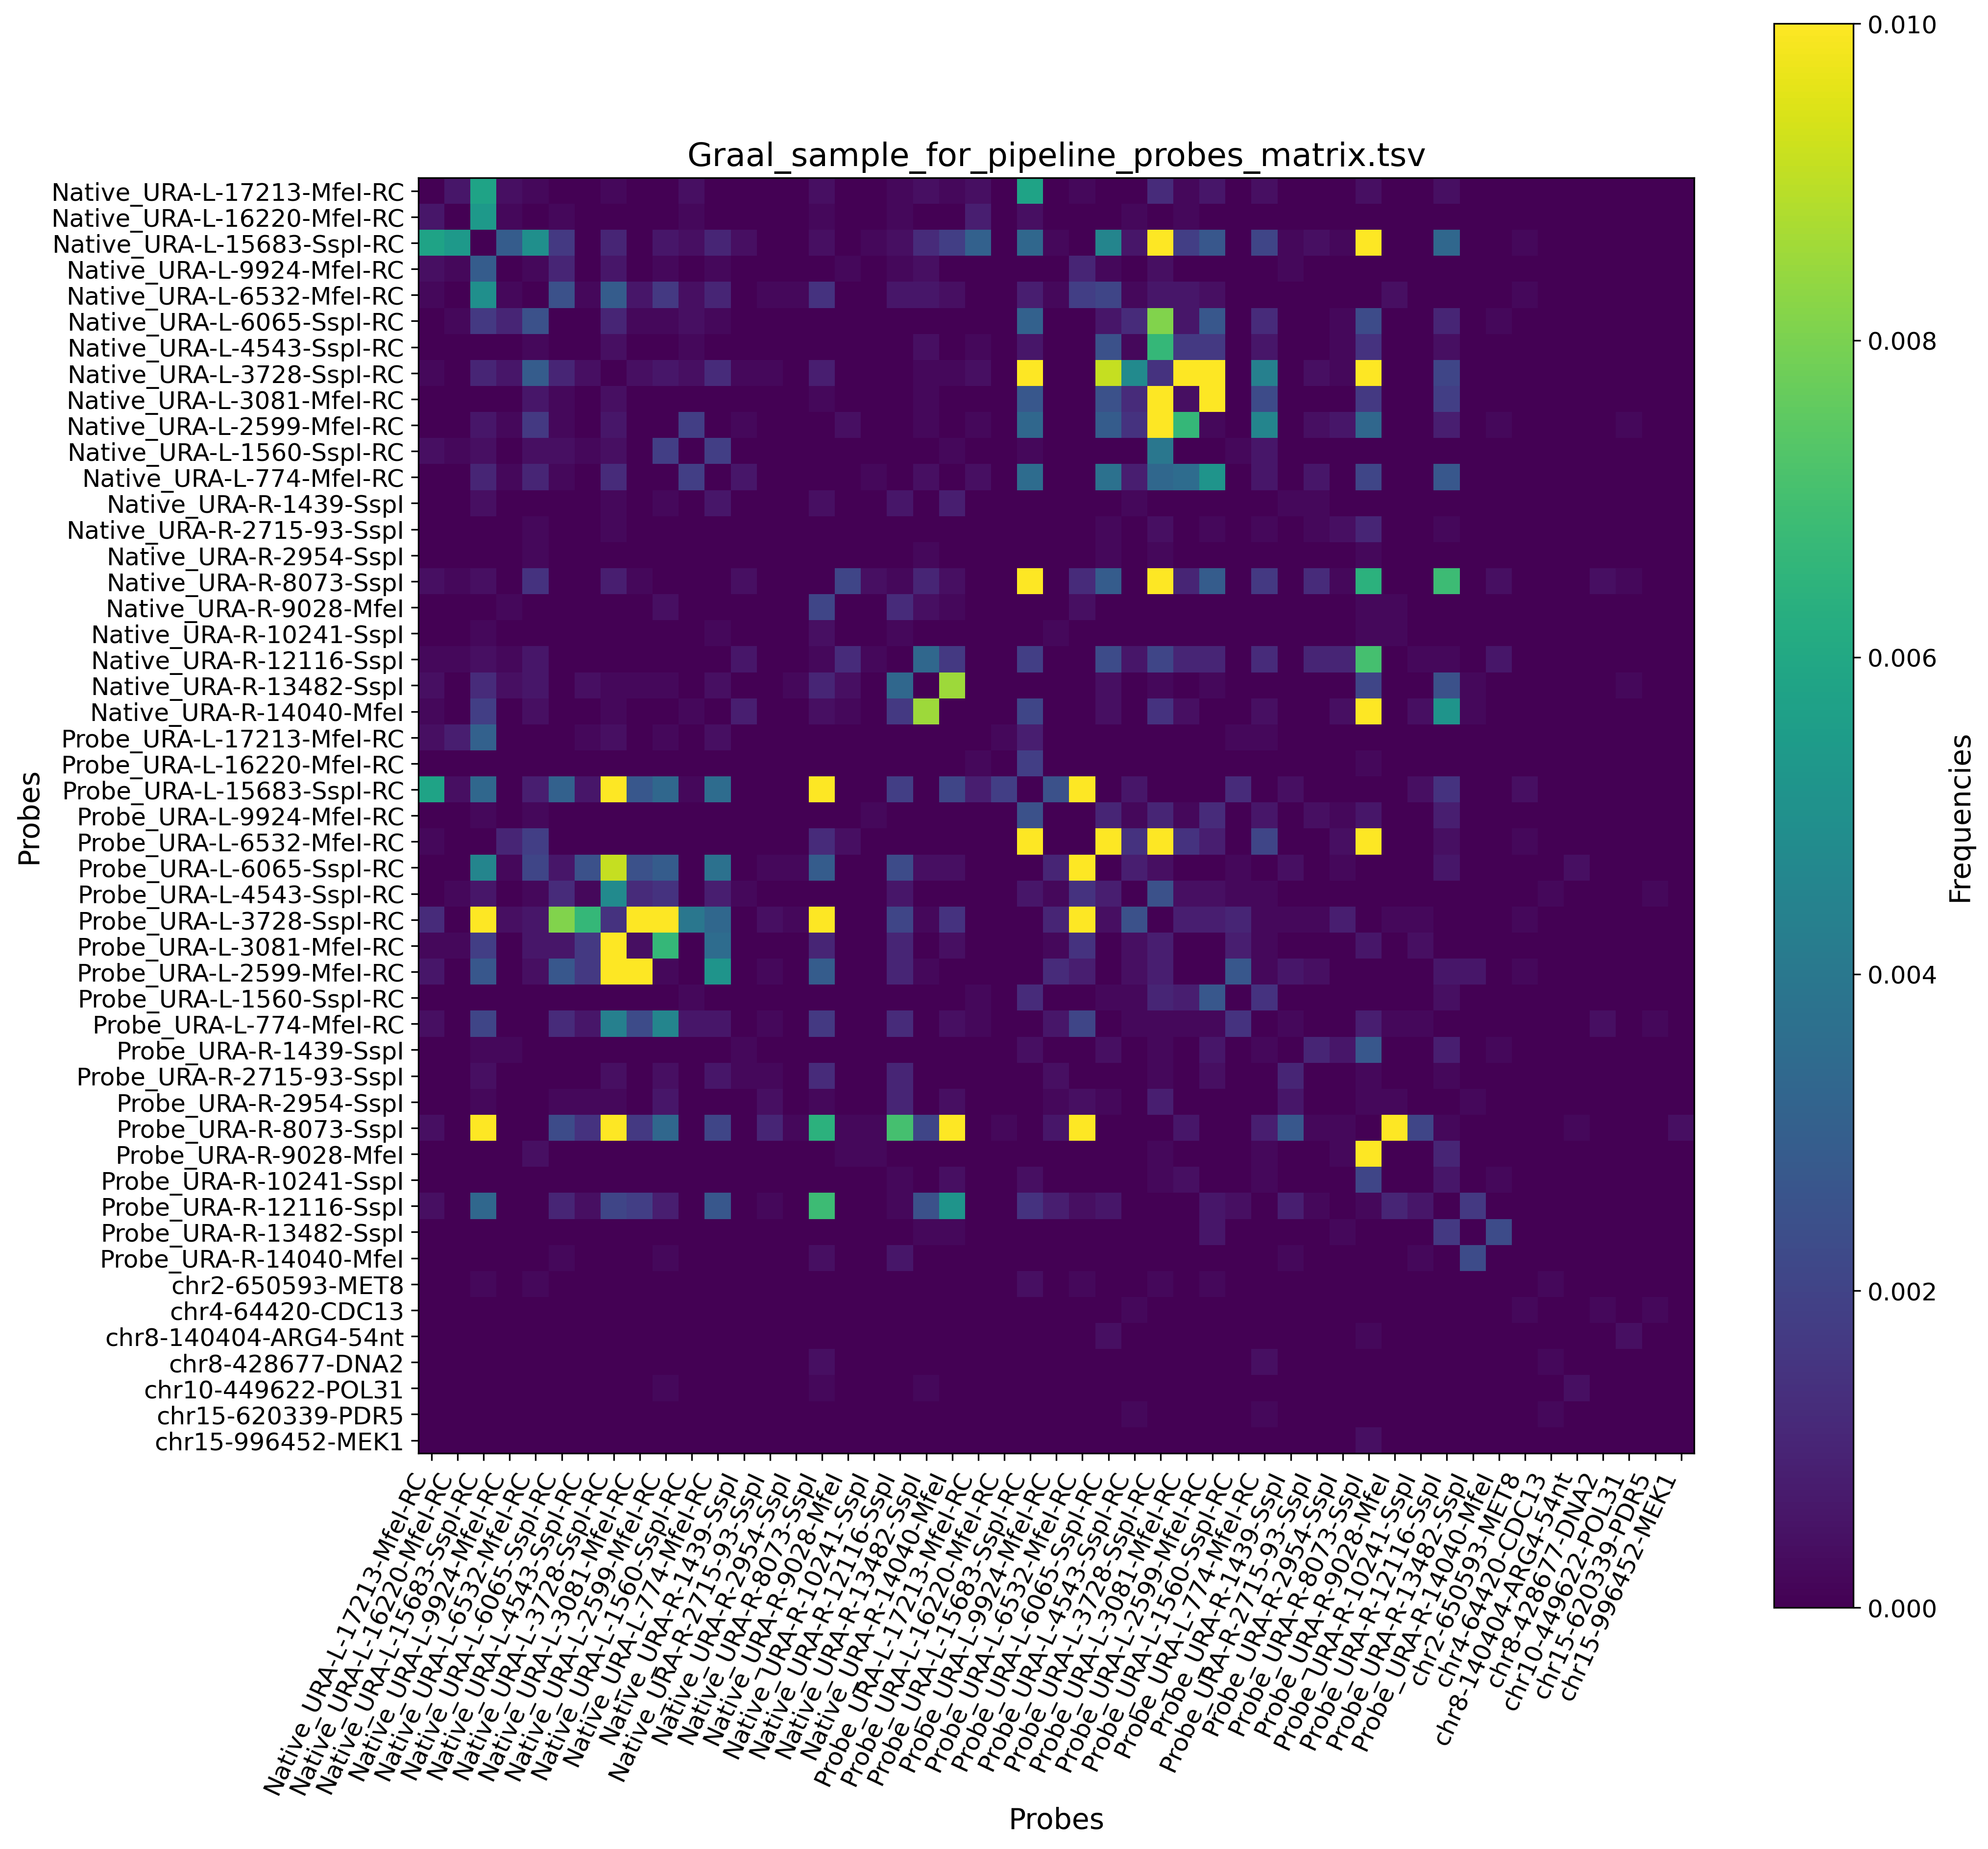

In [51]:
from IPython.display import Image
Image(join(OUTPUTS_DIR, "probes_matrix_plot.png"))

In [67]:
## Classical 4C profile no binning, normalized
ARGS = [
    "profile",
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-f", filtered_path,
    "-a", join(INPUTS_DIR, groups),
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_0kb_profile_frequencies.tsv"),
    "-N",
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)

In [68]:
!{cmd}

In [71]:
## Plot4C
profile_0k_freq_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_0kb_profile_frequencies.tsv")
ARGS = [
    "plot4c",
    "-p", profile_0k_freq_path,
    "-c", capture_associated_path,
    "-o", OUTPUTS_DIR,
    "-C", join(INPUTS_DIR, coords),
    "-e", "png",
    "-H", "600",
    "-W", "1200",
    "-r", "4",
    "-y", "0",
    "-Y", "0.01",
]
cmd = "sshicstuff " + " ".join(ARGS)

In [72]:
!{cmd}

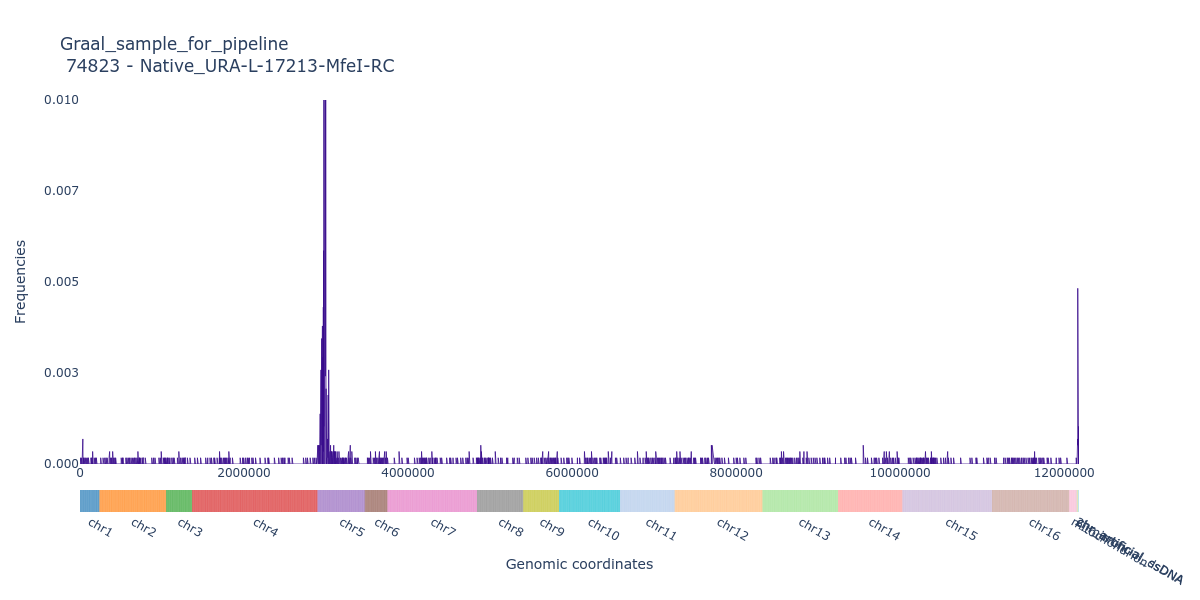

In [74]:
example_plot4c_probe_path = join(OUTPUTS_DIR, "plots/0kb/raw/Graal_sample_for_pipeline_74823_Native_URA-L-17213-MfeI-RC_frequencies_0kb_.png")
Image(example_plot4c_probe_path)